In [1]:
import pandas as pd
import numpy as np
import itertools
import sklearn.model_selection
from collections import defaultdict

# display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# custom helper functions
%load_ext autoreload
%autoreload 2
from helper.general_helper import *

# surprise imorts
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD, NormalPredictor, SlopeOne, CoClustering
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.prediction_algorithms.baseline_only import BaselineOnly


# view plotly in jupyter 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\walke\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
df = pd.read_csv('../../merged_df.csv')
df = df[df['title'].notna()]

In [3]:
cut_down = df.groupby('reviewerID').filter(lambda x: len(x) >= 10)
cut_down = df.groupby('asin').filter(lambda x: len(x)> 30)

In [4]:
# get data into correct format
cut_down = cut_down[['reviewerID', 'asin', 'overall']]

In [5]:
df.index = df.asin
asin_title = dict(df[['title']].drop_duplicates()['title'])

In [6]:
# load into correct format
reader = Reader(rating_scale=(1, 5))

# create testing data and holdout data into surprise formatting
data = Dataset.load_from_df(cut_down, reader)

#### model selection and testing

In [24]:
benchmark = []
for model in [SVD(), NormalPredictor(), SlopeOne(), CoClustering()]:
    cv_score = cross_validate(model, data, measures=['RMSE'], cv=3, verbose=False)
    
    tmp = pd.DataFrame.from_dict(cv_score).mean(axis=0)
    tmp = tmp.append(pd.Series([str(model).split(' ')[0].split('.')[-1]], index=['Model']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Model').sort_values('test_rmse')  

,test_rmse,fit_time,test_time
Model,,,
SVD,0.995075,6.113044,0.424709
CoClustering,1.096063,5.683346,0.354174
SlopeOne,1.171213,0.551690,0.833854
NormalPredictor,1.385606,0.185319,0.403379


In [16]:
gs_model = GridSearchCV(
    algo_class = SVD,
    param_grid = param_grid,
    n_jobs = -1,
    joblib_verbose = 3)

In [29]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=5, n_epochs=40, lr_all=0.005, reg_all=0.2)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.9814


0.98137832026477

In [21]:
param_grid = {
    'n_factors':[5, 10,20, 30],
    'n_epochs': [5, 10, 20, 30], 
    'lr_all': [0.002, 0.005],
    'reg_all': [0.2, 0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(data)
params = gs.best_params['rmse']
svdtuned = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'],lr_all=params['lr_all'], reg_all=params['reg_all'])

In [23]:
svdtuned

In [37]:
cut_down.head(2)

,reviewerID,asin,overall
47,A3ARLR1FNRXSTA,7884890364,5.0
48,A55OWI53KJ4KZ,7884890364,5.0


In [30]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [31]:
df['rounded est'] = round(df.est)
df['rounded_err'] = abs(df['rounded est'] - df.rui)

##### How is our model doing?

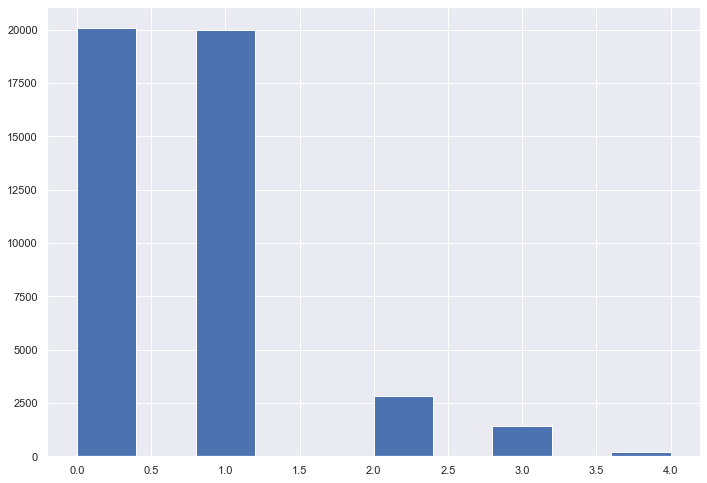

In [32]:
error = df.rounded_err.values
plt.hist(error);

Text(0, 0.5, 'Count')

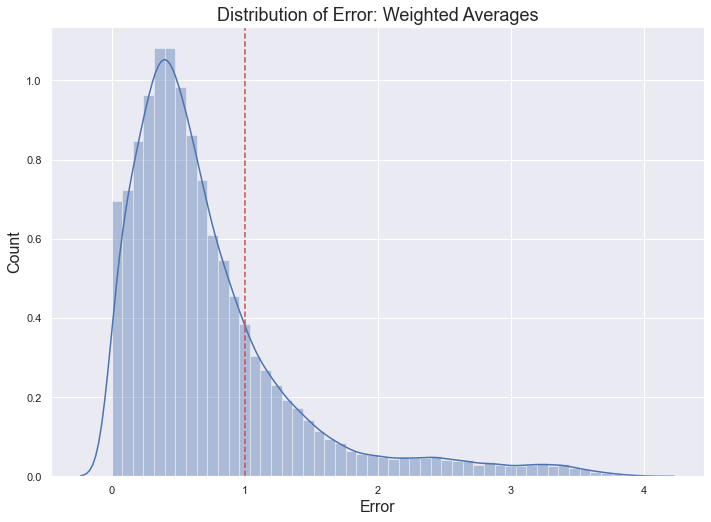

In [33]:
figure = sns.distplot(df.err, kde=True)
plt.axvline(np.median(error),color='r', linestyle='--')
plt.title('Distribution of Error: Weighted Averages', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Error', fontsize=16)
plt.ylabel('Count', fontsize=16)
# plt.savefig(r"../images/svd_error");

In [49]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [59]:
# top_n = get_top_n(predictions, n=10)
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
# algo = BaselineOnly(bsl_options=bsl_options)
# predictions = algo.fit(trainset).test(testset)
# accuracy.rmse(predictions)

In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [44]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [46]:
# fpr, tpr, thresholds = metrics.roc_curve(y, pred)
# metrics.auc(fpr, tpr)

In [48]:
def graph_roc (true_r, est):
    
    fpr, tpr, thresholds = roc_curve(true_r, est)
    auc_ = auc(fpr, tpr)
    plt.plot(fpr,tpr, '-')
    plt.ylabel("FPR/Precision Scores")
    plt.xlabel("TPR/Recall Scores")
    plt.title("ROC Scores and Auc of " + str(round(auc_, 2)))
    plt.show()
    

In [35]:
from surprise.model_selection import KFold


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



kf = KFold(n_splits=5)
algo = SVD()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print(sum(rec for rec in recalls.values()) / len(recalls))

0.7460036884221057
0.7340882598853361
0.7447086366747555
0.7324650673289288
0.7443621495327105
0.7337794866168914
0.7426221891841663
0.7307935174469065
0.7465739526752821
0.735649101251167
